## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [216]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [217]:
#Read the dataset and take a look into first 3 rows of the dataset
df=pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [218]:
#Take a look at the shape of the dataset
df.shape


(294478, 5)

c. The number of unique users in the dataset.

In [219]:
#Find number of unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [220]:
#To find the proportion of users converted in the dataset
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [221]:
#Finding out number of times group and landing page are not in sync
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [222]:
#To get information if there are any attributes with missing values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [223]:
#Taking the dataset which contains correct assignment of landing_page to the respective group
df2=pd.concat([df[(df['group']=='control')& (df['landing_page']!='new_page')],df[(df['group']=='treatment')& (df['landing_page']=='new_page')]])


In [224]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [225]:
#To check if there are any duplicate values in the user_id column
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [226]:
#To find out which user_id has duplicate values
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [227]:
#Getting the row information about the row which contains duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [228]:
#Removing the duplicate record which has the same user_id
df2.drop_duplicates('user_id',inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [229]:
#Average conversion rate for the whole dataset
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [230]:
#Conversion rate for the control group
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [231]:
#Conversion rate for the treatment group
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [232]:
#Probablity that an individual received new page
df2.query('landing_page=="new_page"')['user_id'].count()/df2.shape[0]

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The average conversion rate for the control group is slightly higher than the average conversion rate of Treatment group. But this isn't sufficient evidence that new page is not better than the old page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0:There is no difference in the conversion rates of old page and new page or conversion rate for old page is better than new page.
H1:Conversion rate for new page is better than the old page.

$$ H_0: p_{new}\leq p_{old}$$
$$ H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [233]:
#Convert rate under the null is to be calculated as same as the average conversion rate for the page.
p_new=df2.converted.mean()

p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [234]:
#Convert rate under the null is to be calculated as same as the average conversion rate for the page.
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [235]:
#Number of users who have been assigned with new page
n_new=df2.query("landing_page=='new_page'").user_id.count()
n_new

145310

d. What is $n_{old}$?

In [236]:
#Number of users who have been assigned with old page
n_old=df2.query("landing_page=='old_page'").user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [238]:
#Simulating the new_page converted for the new probabilty for number of times as defined in n_new
new_page_converted=np.random.binomial(n_new,p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [239]:
#Simulating the old_page converted for the old probabilty for number of times as defined in n_old
old_page_converted=np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [240]:
#finding the difference in the new page converted and old page converted values generated using simulation
(new_page_converted/n_new)-(old_page_converted/n_old)

0.0011475149092778081

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [241]:
#repeating the above operation for 10000 samples differences in the conversion means
p_diffs=[]
for _ in range(10000):
    new_page_converted=np.random.binomial(n_new,p_new)
    old_page_converted=np.random.binomial(n_old,p_old)
    p_diffs.append((new_page_converted/n_new)-(old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   16.,   108.,   583.,  1942.,  3126.,  2696.,  1200.,   290.,
           32.,     7.]),
 array([-0.00473741, -0.00374562, -0.00275382, -0.00176202, -0.00077023,
         0.00022157,  0.00121337,  0.00220516,  0.00319696,  0.00418876,
         0.00518055]),
 <a list of 10 Patch objects>)

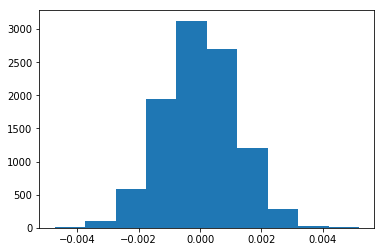

In [242]:
#PLotting histogram for the differnces of conversion values generated using simulations
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)

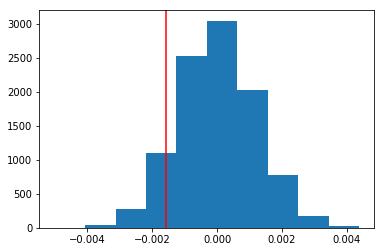

In [243]:
#Generating a histogram for the null values with observed difference marked with a red line
null_vals=np.random.normal(0,p_diffs.std(),len(p_diffs))
plt.hist(null_vals)
plt.axvline(x=obs_diff,color='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [244]:
#Checking what proportions of values are greater than the observed difference in the simulated values of differences
obs_diff=df2.query("landing_page=='new_page'").converted.mean()-df2.query("landing_page=='old_page'").converted.mean()
(obs_diff<p_diffs).mean()


0.90690000000000004

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value is called p-value. p-value means that give the null hypothesis(that there is no difference in the conversion rate for new page as compared to old page) is true then what's the probability of observing something more exetreme than our statistic in favor of the alternative. Here p-value is 0.914 which is greater than our threshold value of 0.05. Hence we fail to reject the NULL hypothesis in favor of alternate hypothesis(new page conversion rate is better than old page conversion rate). 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [245]:
#Importing the required statistical model library
import statsmodels.api as sm
df2.head(2)
#Getting the values for all the required variables

convert_old = df2[(df2['landing_page']=='old_page')&(df2['converted']==1)].converted.count()
convert_new = df2[(df2['landing_page']=='new_page')&(df2['converted']==1)].converted.count()
n_old = df2.query("landing_page=='old_page'").user_id.count() 
n_new = df2.query("landing_page=='new_page'").user_id.count()
#Printing all the variables creating above
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [246]:
#Getting the z value and p-value related to the model created above
z_score,p_value=sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')

In [247]:
#Printing the p-value and z-score value
p_value,z_score

(0.90505831275902449, -1.3109241984234394)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Yes they are quite similar to the p-value obtained in j. I would agree with the findings in j and k. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**.Since we are predicting whether the page gets converted or not which is a binary kind of problem we have to use Logistic regression model for this kind of problem.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [248]:
#Adding intercept variable and dummy variables for the group
df2['intercept']=1
df2[['control','treatment',]]=pd.get_dummies(df2['group'])


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [199]:
#Importing the statsmodel library and creating a logistic regression model
import statsmodels.api as sm
model=sm.Logit(df2['converted'],df2[['intercept','treatment']])
result=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        17:29:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
#getting the summary of the logistic regression model
result.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with **ab_page** using the logistic regression is 0.216,this is different from the previously obtained value because it was a one sided p-value test where as this regression model gives us p-value based on the two sided hypothesis test. Since this is a two-sided hypothesis test.
So in this case the Null hypothesis is $$ H0: p_{new}=p_{old}  $$
$$ H_1: p_{new}\neq p_{old} $$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It's good to add few more variables that might influence the conversion rates. Course name can be a good parameter to add , because that will help us see if the conversion rates vary similarly acorss all the different courses or does it vary more acorss any specific courses. Adding age and gender of participants can also be helpful in predicting the page conversion. Adding too many variables is like a doble edge sword, it may prove benificial if the variables are used properly or else it may lead to Simpson's Paradox.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [249]:
#Getting the countries data and joining it with the existing dataframe df2
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [250]:
### Create the necessary dummy variables for the countries variable
df_new.head(2)
df_new.country.unique()
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [251]:
### Fit Your Linear Model And Obtain the Results

model2=sm.Logit(df_new['converted'],df_new[['intercept','treatment','CA','UK']])
#fit the model
result_2=model2.fit()
#Summary of the model
result_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 Jan 2018   Pseudo R-squ.:               2.323e-05
Time:                        18:37:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [252]:
#Since all our coefficients are in negative, to convert them to exponent values I have taken the inverse of their values

1/np.exp(result_2.params)

intercept    7.310207
treatment    1.015056
CA           1.041599
UK           0.990165
dtype: float64

<a id='conclusions'></a>
## Conclusions
All the independant variables in this model seem to be significant as the p-value is less than 0.05. We can interpret the results as follows. Chances of the page getting converted is 1.04 times more likely in Canada holding treatment to be constant.
Similarly chance of the page getting converted is 0.99 times more likely in UK given treatment to be constant.</br>
**Further additions to the dataset**
As mentioned earlier it would be helpful if gender and age variables are also added to the dataset.
Also the course name will also be helpful.

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.